# Implement Value at Risk & Conditional Value at Risk using / Thomas MEDARD


## Get the Historical Data

In [4]:
pip install pandas-datareader

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip Install seaborn

ERROR: unknown command "Install" - maybe you meant "install"
Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd
import numpy as np
import datetime as dt
from pandas_datareader import data as pdr
from scipy.stats import norm, t
import matplotlib.pyplot as plt

In [9]:
import yfinance as yf
import numpy as np
import pandas as pd
import datetime as dt

# Function to get stock data
def getData(stocks, start, end):
    stockData = yf.download(stocks, start=start, end=end)
    stockData = stockData['Close']  # We only need the closing prices
    returns = stockData.pct_change()  # Calculate daily returns
    meanReturns = returns.mean()  # Calculate mean daily returns
    covMatrix = returns.cov()  # Calculate the covariance matrix of returns
    return returns, meanReturns, covMatrix

# Function to calculate portfolio performance
def portfolioPerformance(weights, meanReturns, covMatrix, Time):
    returns = np.sum(meanReturns * weights) * Time  # Portfolio return
    std = np.sqrt(np.dot(weights.T, np.dot(covMatrix, weights))) * np.sqrt(Time)  # Portfolio volatility
    return returns, std

# List of stocks
stockList = ['CBA', 'BHP', 'TLS', 'NAB', 'WBC', 'STO']
stocks = [stock+'.AX' for stock in stockList]  # Add '.AX' suffix for Australian stocks

# Date range
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=800)

# Get data for the stocks
returns, meanReturns, covMatrix = getData(stocks, start=startDate, end=endDate)
returns = returns.dropna()  # Drop rows with missing data

# Generate random portfolio weights
weights = np.random.random(len(returns.columns))
weights /= np.sum(weights)  # Normalize weights so that their sum is 1

# Add portfolio returns to the DataFrame
returns['portfolio'] = returns.dot(weights)

# Display the portfolio's performance
portfolio_return, portfolio_volatility = portfolioPerformance(weights, meanReturns, covMatrix, Time=252)
print(f'Portfolio Return: {portfolio_return}')
print(f'Portfolio Volatility: {portfolio_volatility}')


[*********************100%***********************]  6 of 6 completed


Portfolio Return: 0.08931831834138704
Portfolio Volatility: 0.12017276383210601


## Historical VaR

No assumptions about the distribution of returns.

In [11]:
def historicalVaR(returns, alpha=5):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the percentile of the distribution at the given alpha confidence level
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)

    # A passed user-defined-function will be passed a Series for evaluation.
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalVaR, alpha=alpha)

    else:
        raise TypeError("Expected returns to be dataframe or series")

def historicalCVaR(returns, alpha=5):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the CVaR for dataframe / series
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= historicalVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()

    # A passed user-defined-function will be passed a Series for evaluation.
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalCVaR, alpha=alpha)

    else:
        raise TypeError("Expected returns to be dataframe or series")

# 100 days
Time = 100

hVaR = -historicalVaR(returns['portfolio'], alpha=5)*np.sqrt(Time)
hCVaR = -historicalCVaR(returns['portfolio'], alpha=5)*np.sqrt(Time)
pRet, pStd = portfolioPerformance(weights, meanReturns, covMatrix, Time)

InitialInvestment = 10000
print('Expected Portfolio Return:      ', round(InitialInvestment*pRet,2))
print('Value at Risk 95th CI    :      ', round(InitialInvestment*hVaR,2))
print('Conditional VaR 95th CI  :      ', round(InitialInvestment*hCVaR,2))

Expected Portfolio Return:       354.44
Value at Risk 95th CI    :       1251.49
Conditional VaR 95th CI  :       1738.63


## Parametric VaR


Assumption on the distribution of returns abd use the historical portfolio returns and standard deviations (estimates) to define parameters for the model. Here we have implemented two parametric VaR models:
 - normal distribution
 - t-distribution

In [12]:
def var_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    # because the distribution is symmetric
    if distribution == 'normal':
        VaR = norm.ppf(1-alpha/100)*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        VaR = np.sqrt((nu-2)/nu) * t.ppf(1-alpha/100, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return VaR

def cvar_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    if distribution == 'normal':
        CVaR = (alpha/100)**-1 * norm.pdf(norm.ppf(alpha/100))*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        xanu = t.ppf(alpha/100, nu)
        CVaR = -1/(alpha/100) * (1-nu)**(-1) * (nu-2+xanu**2) * t.pdf(xanu, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return CVaR

normVaR = var_parametric(pRet, pStd)
normCVaR = cvar_parametric(pRet, pStd)

tVaR = var_parametric(pRet, pStd, distribution='t-distribution')
tCVaR = cvar_parametric(pRet, pStd, distribution='t-distribution')

print("Normal VaR 95th CI       :      ", round(InitialInvestment*normVaR,2))
print("Normal CVaR 95th CI      :      ", round(InitialInvestment*normCVaR,2))
print("t-dist VaR 95th CI       :      ", round(InitialInvestment*tVaR,2))
print("t-dist CVaR 95th CI      :      ", round(InitialInvestment*tCVaR,2))

Normal VaR 95th CI       :       890.74
Normal CVaR 95th CI      :       1207.07
t-dist VaR 95th CI       :       846.65
t-dist CVaR 95th CI      :       1277.82


## Monte Carlo VaR & CVaR

In this section we use a Monte Carlo simulation of a stock portfolio and then use the functions for historical VaR and CVaR to calculate our risk parameters.

The main advantage here is we could define individual models/stock dynamics for individual assets

In [13]:
# Monte Carlo Method
mc_sims = 400 # number of simulations
T = 100 #timeframe in days

meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

initialPortfolio = 10000

for m in range(0, mc_sims):
    # MC loops
    Z = np.random.normal(size=(T, len(weights)))
    L = np.linalg.cholesky(covMatrix)
    dailyReturns = meanM + np.inner(L, Z)
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio

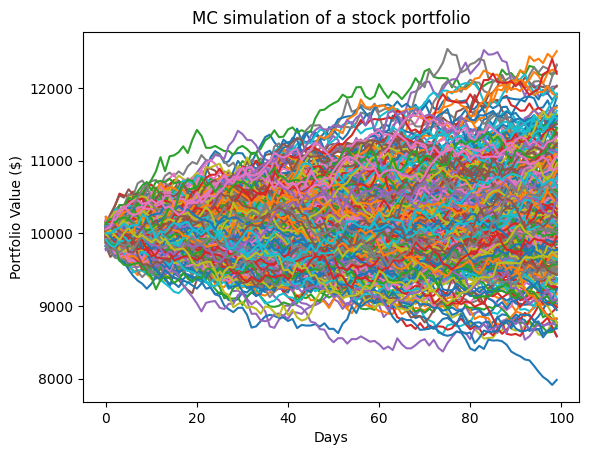

In [14]:
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()

In [15]:
def mcVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: percentile on return distribution to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")

def mcCVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: CVaR or Expected Shortfall to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")

In [16]:
portResults = pd.Series(portfolio_sims[-1,:])

VaR = initialPortfolio - mcVaR(portResults, alpha=5)
CVaR = initialPortfolio - mcCVaR(portResults, alpha=5)

print('VaR ${}'.format(round(VaR,2)))
print('CVaR ${}'.format(round(CVaR,2)))

VaR $921.88
CVaR $1196.08


## Comparison of each VaR & CVaR methods

In [17]:
print("\nVaR:")

print(' historical VaR 95th CI   :      ', round(InitialInvestment*hVaR,2))
print(" Normal VaR 95th CI       :      ", round(InitialInvestment*normVaR,2))
print(" t-dist VaR 95th CI       :      ", round(InitialInvestment*tVaR,2))
print(" MC VaR  95th CI          :      ", round(VaR,2))


print("\nCVaR:")

print(' historical CVaR 95th CI  :      ', round(InitialInvestment*hCVaR,2))
print(" Normal CVaR 95th CI      :      ", round(InitialInvestment*normCVaR,2))
print(" t-dist CVaR 95th CI      :      ", round(InitialInvestment*tCVaR,2))
print(" MC CVaR 95th CI          :      ", round(CVaR,2))


VaR:
 historical VaR 95th CI   :       1251.49
 Normal VaR 95th CI       :       890.74
 t-dist VaR 95th CI       :       846.65
 MC VaR  95th CI          :       921.88

CVaR:
 historical CVaR 95th CI  :       1738.63
 Normal CVaR 95th CI      :       1207.07
 t-dist CVaR 95th CI      :       1277.82
 MC CVaR 95th CI          :       1196.08
